# Deep Learning Models

We compare several deep learning models to test their performance on EEG data

## 1. Simple CNN

### 1.1 Data Preparation

In [1]:
# Load one subject's data
import numpy as np
import os
from pathlib import Path

DATA = Path("../data/raw")
subject = 'S001'
X = np.load(os.path.join(DATA, subject + '_X.npy'))
y = np.load(os.path.join(DATA, subject + '_y.npy'))
X.shape, y.shape

((655, 7501), (655,))

In [10]:
# Combine data from all subjects

subjects = ["S001", "S002", "S003"]

Xs, ys, groups = [], [], []
for i, sid in enumerate(subjects):
    X = np.load(os.path.join(DATA, sid + '_X.npy'))  # (N, 7501)
    y = np.load(os.path.join(DATA, sid + '_y.npy'))  # (N,)
    Xs.append(X)
    ys.append(y)
    groups.append(np.full(len(y), i))  # subject id per epoch

X_all = np.concatenate(Xs, axis=0)
y_all = np.concatenate(ys, axis=0)
g_all = np.concatenate(groups, axis=0)

print(X_all.shape, y_all.shape, g_all.shape)

(2542, 7501) (2542,) (2542,)


In [11]:
test_subject = 2  # (2 = S003)
train_idx = (g_all != test_subject) # boolean mask
test_idx  = (g_all == test_subject)

X_train, y_train = X_all[train_idx], y_all[train_idx]
X_test,  y_test  = X_all[test_idx],  y_all[test_idx]

X_train = X_train[:, None, :]  # (N_train, 1, 7501) (add channel dim)
X_test  = X_test[:, None, :] # (N_test, 1, 7501) (add channel dim)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1719, 1, 7501), (1719,), (823, 1, 7501), (823,))

### 1.2 Data Preprocessing

We normalize the EEG data per epoch to ensure consistent scaling across samples.

In [14]:
mean = X_train.mean()
std  = X_train.std() + 1e-8 # avoid div by zero

X_train = (X_train - mean) / std
X_test  = (X_test  - mean) / std

print("train mean/std:", X_train.mean(), X_train.std())
print("test  mean/std:", X_test.mean(), X_test.std())

y_train[0]


train mean/std: 1.4107014961866683e-19 0.9999999900000001
test  mean/std: -0.00019945469165636413 0.46124000024736217


np.str_('S')

In [15]:
# Encode y-train and y-test

train_classes = sorted(set(y_train))
label2id = {lbl: i for i, lbl in enumerate(train_classes)}
id2label = {i: lbl for lbl, i in label2id.items()}

y_train_id = np.array([label2id[lbl] for lbl in y_train], dtype=np.int64)
y_test_id = np.array([label2id[lbl] for lbl in y_test], dtype=np.int64)

print("label2id:", label2id)
print("y_train_id unique:", np.unique(y_train_id))
print("y_test_id unique :", np.unique(y_test_id))

label2id: {np.str_('A'): 0, np.str_('K'): 1, np.str_('MS'): 2, np.str_('REM'): 3, np.str_('S'): 4, np.str_('Soff'): 5, np.str_('Son'): 6}
y_train_id unique: [0 1 2 3 4 5 6]
y_test_id unique : [0 1 2 3 4 5 6]


In [16]:
# Convert to torch tensors

import torch
from torch.utils.data import TensorDataset, DataLoader

Xtr = torch.tensor(X_train, dtype=torch.float32)
ytr = torch.tensor(y_train_id, dtype=torch.long)

Xte = torch.tensor(X_test, dtype=torch.float32)
yte = torch.tensor(y_test_id, dtype=torch.long)

train_loader = DataLoader(TensorDataset(Xtr, ytr), batch_size=64, shuffle=True)
test_loader  = DataLoader(TensorDataset(Xte, yte), batch_size=64, shuffle=False)



In [18]:
# Class weights to handle class imbalance

from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch

classes = np.arange(len(label2id))
weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train_id)
class_weights = torch.tensor(weights, dtype=torch.float32)
print({id2label[i]: float(class_weights[i]) for i in range(len(classes))})



{np.str_('A'): 7.016326427459717, np.str_('K'): 0.576458752155304, np.str_('MS'): 35.081634521484375, np.str_('REM'): 0.6154672503471375, np.str_('S'): 0.31686636805534363, np.str_('Soff'): 8.770408630371094, np.str_('Son'): 5.011662006378174}


In [21]:
# Balanced sampling

import torch
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
import numpy as np

# per-sample weights = weight of its class
sample_weights = np.array([class_weights[int(c)] for c in y_train_id], dtype=np.float32)
n_classes = len(label2id)

sampler = WeightedRandomSampler(
    weights=torch.tensor(sample_weights),
    num_samples=len(sample_weights),
    replacement=True
)

train_loader_balanced = DataLoader(
    TensorDataset(Xtr, ytr),
    batch_size=64,
    sampler=sampler
)


### 1.3 Model 

In [22]:
import torch.nn as nn

class TinyEEGCNN(nn.Module):
    def __init__(self, n_classes: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=7, padding=3),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(32, 64, kernel_size=7, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(64, 128, kernel_size=7, padding=3),
            nn.BatchNorm1d(128),
            nn.ReLU(),

            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),

            nn.Dropout(0.3),
            nn.Linear(128, n_classes),
        )

    def forward(self, x):
        return self.net(x)


In [34]:
# Model visualization

from torchinfo import summary

summary(
    model,
    input_size=(64, 1, 7501),  # (batch, channels, time)
    col_names=("input_size", "output_size", "num_params", "kernel_size", "mult_adds"),
    depth=4
)


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds
TinyEEGCNN                               [64, 1, 7501]             [64, 7]                   --                        --                        --
├─Sequential: 1-1                        [64, 1, 7501]             [64, 7]                   --                        --                        --
│    └─Conv1d: 2-1                       [64, 1, 7501]             [64, 32, 7501]            256                       [7]                       122,896,384
│    └─BatchNorm1d: 2-2                  [64, 32, 7501]            [64, 32, 7501]            64                        --                        4,096
│    └─ReLU: 2-3                         [64, 32, 7501]            [64, 32, 7501]            --                        --                        --
│    └─MaxPool1d: 2-4                    [64, 32, 7501]            [64, 32, 3750]            

In [ ]:
# Export for ONNX

# import torch

# model.eval()

# # dummy input must match your real input shape: (batch, channels, time)
# dummy = torch.randn(1, 1, 7501, device=next(model.parameters()).device)

# onnx_path = "tinyeegcnn.onnx"

# torch.onnx.export(
#     model,
#     dummy,
#     onnx_path,
#     export_params=False,
#     do_constant_folding=True,
#     input_names=["eeg"],
#     output_names=["logits"],
#     dynamo=True,
# )

# print("Saved:", onnx_path)


[torch.onnx] Obtain model graph for `TinyEEGCNN([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `TinyEEGCNN([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Applied 3 of general pattern rewrite rules.
Saved: tinyeegcnn.onnx


### 1.4 Training

In [ ]:
import torch
from tqdm.auto import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
model = TinyEEGCNN(n_classes=n_classes).to(device)

epochs = 10

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

def run_epoch(loader, train: bool):
    model.train(train)
    total_loss, correct, n = 0.0, 0, 0

    for xb, yb in tqdm(loader, leave=False):
        xb, yb = xb.to(device), yb.to(device)

        logits = model(xb)
        loss = criterion(logits, yb)

        if train:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        total_loss += loss.item() * xb.size(0)
        correct += (logits.argmax(1) == yb).sum().item()
        n += xb.size(0)

    return total_loss / n, correct / n

for epoch in range(1, epochs + 1):
    tr_loss, tr_acc = run_epoch(train_loader, train=True)
    te_loss, te_acc = run_epoch(test_loader,  train=False)
    print(f"Epoch {epoch:02d} | train loss {tr_loss:.4f} acc {tr_acc:.3f} | test loss {te_loss:.4f} acc {te_acc:.3f}")


### 1.5 Evaluation

In [27]:
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import numpy as np

model.eval()
all_preds, all_true = [], []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        logits = model(xb).cpu().numpy()
        preds = logits.argmax(axis=1)
        all_preds.append(preds)
        all_true.append(yb.numpy())

y_pred = np.concatenate(all_preds)
y_true = np.concatenate(all_true)

print("Macro F1:", f1_score(y_true, y_pred, average="macro"))

# readable per-class stats
target_names = [id2label[i] for i in range(n_classes)]
print(classification_report(y_true, y_pred, target_names=target_names, digits=3))



Macro F1: 0.1527399748803789
              precision    recall  f1-score   support

           A      0.000     0.000     0.000        20
           K      0.667     0.011     0.021       378
          MS      0.024     1.000     0.047         2
         REM      0.453     0.867     0.595       256
           S      0.242     0.317     0.275       123
        Soff      0.045     0.143     0.069        14
         Son      0.059     0.067     0.062        30

    accuracy                          0.329       823
   macro avg      0.213     0.343     0.153       823
weighted avg      0.486     0.329     0.239       823



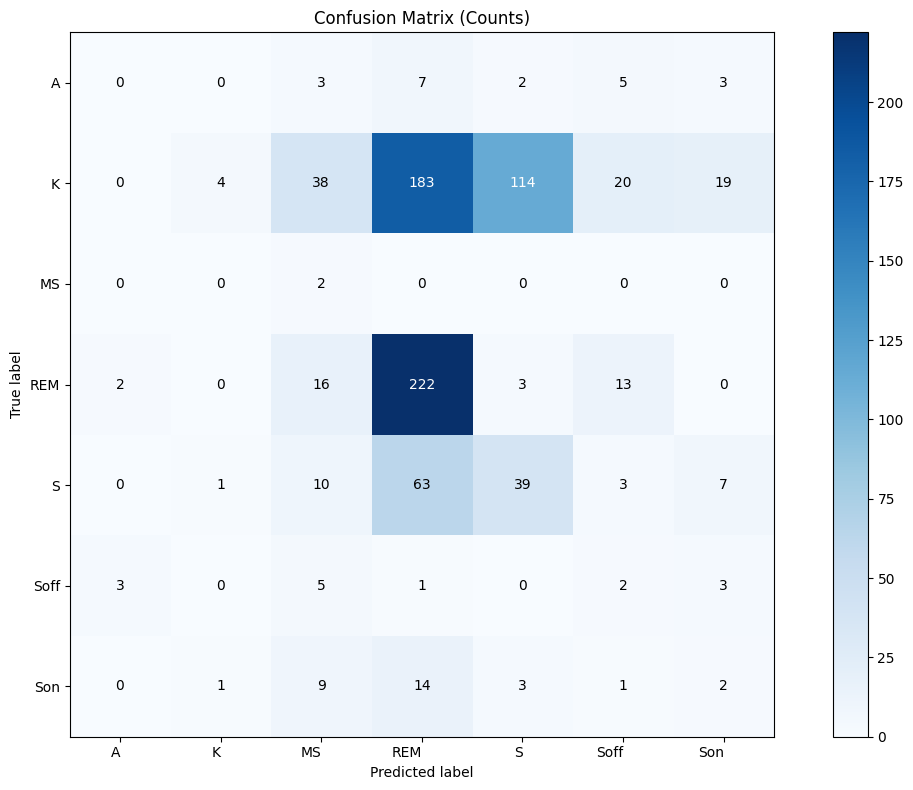

In [29]:
# PLot confusion matrix

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 8))
plt.imshow(cm, cmap='Blues')
plt.colorbar()

plt.xticks(np.arange(n_classes), target_names, ha='right')
plt.yticks(np.arange(n_classes), target_names)

# annotate each cell
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j],
                 ha="center", va="center",
                 color="white" if cm[i, j] > cm.max() * 0.5 else "black")

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix (Counts)')
plt.tight_layout()
plt.show()


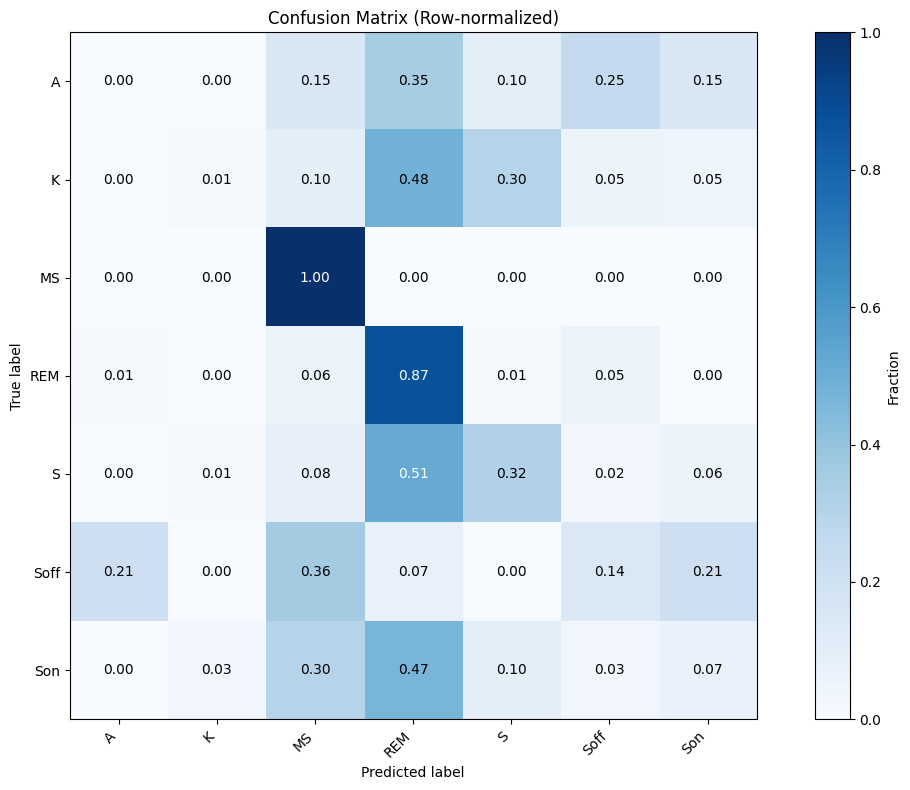

In [30]:
# Normalized confusion matrix

cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(12, 8))
plt.imshow(cm_norm, cmap='Blues', vmin=0, vmax=1)
plt.colorbar(label="Fraction")

plt.xticks(np.arange(n_classes), target_names, rotation=45, ha='right')
plt.yticks(np.arange(n_classes), target_names)

for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        val = cm_norm[i, j]
        plt.text(j, i, f"{val:.2f}",
                 ha="center", va="center",
                 color="white" if val > 0.5 else "black")

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix (Row-normalized)')
plt.tight_layout()
plt.show()


## 2. CNN + GRU Model

Core Idea:
* Treat each 30 s epoch as a sequence of shorter windows
* CNN encodes each short window
* GRU models the temporal evolution across the 30 s epoch

> “The CNN is applied independently to each short window. The GRU never sees raw EEG — it only sees a sequence of learned features, one per window.”

### 2.1 Data Preparation

In [38]:
def make_windows(data, window_size, step_size):
    """
    X: (N, C, T) array of data
    window_size: int, size of each window (in samples)
    step_size: int, step size between windows (in samples)
    Returns:
        windows: (N, num_windows, C, window_size) array of windows
    """

    N, C, T = data.shape
    
    if window_size > T:
        raise ValueError(f"window_size ({window_size}) > T ({T})")
    if step_size <= 0:
        raise ValueError("step_size must be > 0")

    num_windows = 1 + (T - window_size) // step_size
    windows = np.empty((N, num_windows, C, window_size), dtype=data.dtype)

    for i in range(num_windows):
        start = i * step_size
        end = start + window_size
        windows[:, i, :, :] = data[:, :, start:end]

    return windows

In [42]:
# Make windows of 1 second (250 samples) with 50% overlap (step size 125 samples)
window_size = 250
step_size = 125
Xw = make_windows(X_train, window_size, step_size)
Xw.shape  # (N, num_windows, C, window_size)

(1719, 59, 1, 250)

### 2.2 Data Preprocessing

In [54]:
X_train_w = make_windows(X_train, window_size, step_size)
X_test_w  = make_windows(X_test,  window_size, step_size)
X_train_w.shape, X_test_w.shape

((1719, 59, 1, 250), (823, 59, 1, 250))

In [55]:
y_train_id.shape, y_test_id.shape

((1719,), (823,))

### 2.3 Model

In [44]:
def cnn_geom(X, encoder):
    """
    X: (B, S, C, T) array of data
    encoder: nn.Module that processes (B*S, C, T) inputs and outputs (B*S, F) features
    Returns:
        geom_features: (B, S, F) array of geometric features
    """
    B, S, C, T = X.shape
    X_reshaped = X.reshape(B * S, C, T)  # (B*S, C, T)
    features = encoder(X_reshaped)       # (B*S, F)
    F = features.shape[1]
    geom_features = features.reshape(B, S, F)  # (B, S, F)
    return geom_features

In [48]:
import torch
import torch.nn as nn

B, S, F = 4, 10, 128
H = 64

geom_features = torch.randn(B, S, F)

gru = nn.GRU(
    input_size=F,
    hidden_size=H,
    batch_first=True,
    bidirectional=True
)

out, h = gru(geom_features)

print("out:", out.shape)  # (4, 10, 128)
print("h:", h.shape)      # (2, 4, 64)

rep = out.mean(dim=1)  # (4, 128)
logits = nn.Linear(2 * H, n_classes)(rep)  # (4, n_classes)
logits.shape == (B, n_classes)


out: torch.Size([4, 10, 128])
h: torch.Size([2, 4, 64])


True

In [49]:
class CNNGRU(nn.Module):
    def __init__(self, n_classes: int, gru_hidden: int = 64, feat_dim: int = 128):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=7, padding=3),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(32, 64, kernel_size=7, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(64, feat_dim, kernel_size=7, padding=3),
            nn.BatchNorm1d(128),
            nn.ReLU(),

            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
        )
        self.gru = nn.GRU(
            input_size=feat_dim,
            hidden_size=gru_hidden,
            batch_first=True,
            bidirectional=True
        )
        self.fc = nn.Linear(2 * gru_hidden, n_classes)

    def forward(self, x):
        geom_features = cnn_geom(x, self.encoder)  # (B, S, F)
        out, _ = self.gru(geom_features)           # (B, S, 2*H)
        rep = out.mean(dim=1)                      # (B, 2*H)
        logits = self.fc(rep)                      # (B, n_classes)
        return logits


In [52]:
from torchinfo import summary
import torch

B, S, win = 2, 59, 250
x = torch.randn(B, S, 1, win)

model = CNNGRU(n_classes=7, feat_dim=128, gru_hidden=64)

summary(
    model,
    input_data=x,
    col_names=("input_size", "output_size", "num_params", "mult_adds"),
    depth=4
)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Mult-Adds
CNNGRU                                   [2, 59, 1, 250]           [2, 7]                    --                        --
├─Sequential: 1-1                        [118, 1, 250]             [118, 128]                --                        --
│    └─Conv1d: 2-1                       [118, 1, 250]             [118, 32, 250]            256                       7,552,000
│    └─BatchNorm1d: 2-2                  [118, 32, 250]            [118, 32, 250]            64                        7,552
│    └─ReLU: 2-3                         [118, 32, 250]            [118, 32, 250]            --                        --
│    └─MaxPool1d: 2-4                    [118, 32, 250]            [118, 32, 125]            --                        --
│    └─Conv1d: 2-5                       [118, 32, 125]            [118, 64, 125]            14,400                    212,400,00

### 2.4 Training

In [56]:
import torch
from torch.utils.data import TensorDataset, DataLoader

Xtr = torch.tensor(X_train_w, dtype=torch.float32)
ytr = torch.tensor(y_train_id, dtype=torch.long)
Xte = torch.tensor(X_test_w, dtype=torch.float32)
yte = torch.tensor(y_test_id, dtype=torch.long)

train_loader = DataLoader(TensorDataset(Xtr, ytr), batch_size=32, shuffle=True)
test_loader  = DataLoader(TensorDataset(Xte, yte), batch_size=32, shuffle=False)


In [57]:
import numpy as np
from collections import Counter
import torch.nn as nn

counts = Counter(y_train_id.tolist())
n_classes = len(counts)
total = sum(counts.values())

weights = np.array([total / (n_classes * counts[c]) for c in range(n_classes)], dtype=np.float32)
class_weights = torch.tensor(weights, dtype=torch.float32)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = CNNGRU(n_classes=7, feat_dim=128, gru_hidden=64).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)


In [60]:
from tqdm.auto import tqdm
from sklearn.metrics import f1_score, confusion_matrix, classification_report

epochs = 10

def run_epoch(loader, train: bool):
    model.train(train)
    total_loss, correct, n = 0.0, 0, 0

    for xb, yb in tqdm(loader, leave=False):
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        loss = criterion(logits, yb)

        if train:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        total_loss += loss.item() * xb.size(0)
        correct += (logits.argmax(1) == yb).sum().item()
        n += xb.size(0)

    return total_loss / n, correct / n

def eval_all(loader):
    model.eval()
    ys, ps = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            pred = model(xb).argmax(1).cpu().numpy()
            ps.append(pred)
            ys.append(yb.numpy())
    y_true = np.concatenate(ys)
    y_pred = np.concatenate(ps)
    macro = f1_score(y_true, y_pred, average="macro")
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(n_classes))
    return macro, cm, y_true, y_pred

for epoch in range(1, epochs + 1):
    tr_loss, tr_acc = run_epoch(train_loader, train=True)
    macro, cm, y_true, y_pred = eval_all(test_loader)
    print(f"Epoch {epoch:02d} | train loss {tr_loss:.4f} acc {tr_acc:.3f} | test macroF1 {macro:.3f}")


Epoch 01 | train loss 1.7115 acc 0.324 | test macroF1 0.069


Epoch 02 | train loss 1.4126 acc 0.468 | test macroF1 0.080


Epoch 03 | train loss 1.3507 acc 0.573 | test macroF1 0.080


Epoch 04 | train loss 1.2274 acc 0.567 | test macroF1 0.178


Epoch 05 | train loss 1.1363 acc 0.583 | test macroF1 0.068


Epoch 06 | train loss 1.0669 acc 0.589 | test macroF1 0.122


Epoch 07 | train loss 1.0598 acc 0.615 | test macroF1 0.081


Epoch 08 | train loss 0.9945 acc 0.606 | test macroF1 0.217


Epoch 09 | train loss 0.9423 acc 0.615 | test macroF1 0.201


Epoch 10 | train loss 0.9315 acc 0.638 | test macroF1 0.080


### 2.5 Evaluation

In [61]:
target_names = [id2label[i] for i in range(n_classes)]
print(classification_report(y_true, y_pred, target_names=target_names, digits=3))
print(cm)


              precision    recall  f1-score   support

           A      0.500     0.050     0.091        20
           K      0.000     0.000     0.000       378
          MS      0.000     0.000     0.000         2
         REM      0.310     0.973     0.471       256
           S      0.000     0.000     0.000       123
        Soff      0.000     0.000     0.000        14
         Son      0.000     0.000     0.000        30

    accuracy                          0.304       823
   macro avg      0.116     0.146     0.080       823
weighted avg      0.109     0.304     0.149       823

[[  1   0   0  15   1   0   3]
 [  1   0   0 375   0   0   2]
 [  0   0   0   2   0   0   0]
 [  0   0   0 249   4   0   3]
 [  0   0   0 122   0   0   1]
 [  0   0   0  10   0   0   4]
 [  0   0   0  29   1   0   0]]


c:\Users\mravi\Documents\GitHub\eeg-idun-sleep\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\mravi\Documents\GitHub\eeg-idun-sleep\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\mravi\Documents\GitHub\eeg-idun-sleep\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, 

In [ ]:
    


# Make the above code a function
def plot_confusion_matrix_with_totals(y_true, y_pred, target_names):
    """
    Plots a confusion matrix with total counts per class on the y-axis labels.

    Args:
        y_true: Array of true labels.
        y_pred: Array of predicted labels.
        target_names: List of class names corresponding to label indices.
    """
    cm = confusion_matrix(y_true, y_pred)
    n_classes = len(target_names)

    # Calculate totals per class (sum of each row)
    class_totals = cm.sum(axis=1)

    # Create new labels for the y-axis: "ClassName (Total)"
    y_labels_with_totals = [f"{name} (n={total})" for name, total in zip(target_names, class_totals)]

    plt.figure(figsize=(12, 8))
    plt.imshow(cm, cmap='Blues')
    plt.colorbar()

    # Set ticks - Note the use of y_labels_with_totals for yticks
    plt.xticks(np.arange(n_classes), target_names, rotation=45, ha='right')
    plt.yticks(np.arange(n_classes), y_labels_with_totals)

    # Annotate each cell
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j],
                     ha="center", va="center",
                     color="white" if cm[i, j] > cm.max() * 0.5 else "black")

    plt.xlabel('Predicted label')
    plt.ylabel('True label (Actual)')
    plt.title('Confusion Matrix with Class Totals')
    plt.tight_layout()
    plt.show()

plot_confusion_matrix_with_totals(y_true, y_pred, target_names)

Ooof.. almost everything is predicted as REM. Needs more tuning.

### 2.6 Model Tuning

Let's tune the model so that instead of average pooling for GRU readout, we use max pooling.

In [65]:
class CNNGRU_2(nn.Module):
    def __init__(self, n_classes: int, gru_hidden: int = 64, feat_dim: int = 128):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=7, padding=3),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(32, 64, kernel_size=7, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(64, feat_dim, kernel_size=7, padding=3),
            nn.BatchNorm1d(128),
            nn.ReLU(),

            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
        )
        self.gru = nn.GRU(
            input_size=feat_dim,
            hidden_size=gru_hidden,
            batch_first=True,
            bidirectional=True
        )
        self.fc = nn.Linear(2 * gru_hidden, n_classes)

    def forward(self, x):
        geom_features = cnn_geom(x, self.encoder)  # (B, S, F)
        out, _ = self.gru(geom_features)           # (B, S, 2*H)
        rep, _ = out.max(dim=1)                      # (B, 2*H) -> Only change from v1 - use max pooling instead of mean
        logits = self.fc(rep)                      # (B, n_classes)
        return logits


In [68]:
import numpy as np
from collections import Counter
import torch.nn as nn

counts = Counter(y_train_id.tolist())
n_classes = len(counts)
total = sum(counts.values())

weights = np.array([total / (n_classes * counts[c]) for c in range(n_classes)], dtype=np.float32)
class_weights = torch.tensor(weights, dtype=torch.float32)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = CNNGRU_2(n_classes=7, feat_dim=128, gru_hidden=64).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)


In [69]:
from tqdm.auto import tqdm
from sklearn.metrics import f1_score, confusion_matrix, classification_report

epochs = 10

def run_epoch(loader, train: bool):
    model.train(train)
    total_loss, correct, n = 0.0, 0, 0

    for xb, yb in tqdm(loader, leave=False):
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        loss = criterion(logits, yb)

        if train:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        total_loss += loss.item() * xb.size(0)
        correct += (logits.argmax(1) == yb).sum().item()
        n += xb.size(0)

    return total_loss / n, correct / n

def eval_all(loader):
    model.eval()
    ys, ps = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            pred = model(xb).argmax(1).cpu().numpy()
            ps.append(pred)
            ys.append(yb.numpy())
    y_true = np.concatenate(ys)
    y_pred = np.concatenate(ps)
    macro = f1_score(y_true, y_pred, average="macro")
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(n_classes))
    return macro, cm, y_true, y_pred

for epoch in range(1, epochs + 1):
    tr_loss, tr_acc = run_epoch(train_loader, train=True)
    macro, cm, y_true, y_pred = eval_all(test_loader)
    print(f"Epoch {epoch:02d} | train loss {tr_loss:.4f} acc {tr_acc:.3f} | test macroF1 {macro:.3f}")


Epoch 01 | train loss 1.7824 acc 0.282 | test macroF1 0.077


Epoch 02 | train loss 1.4618 acc 0.465 | test macroF1 0.108


Epoch 03 | train loss 1.3442 acc 0.570 | test macroF1 0.077


Epoch 04 | train loss 1.2319 acc 0.599 | test macroF1 0.243


Epoch 05 | train loss 1.0859 acc 0.650 | test macroF1 0.144


Epoch 06 | train loss 1.0323 acc 0.674 | test macroF1 0.139


Epoch 07 | train loss 0.9236 acc 0.716 | test macroF1 0.144


Epoch 08 | train loss 0.8972 acc 0.735 | test macroF1 0.281


Epoch 09 | train loss 0.8615 acc 0.749 | test macroF1 0.202


Epoch 10 | train loss 0.8037 acc 0.764 | test macroF1 0.068


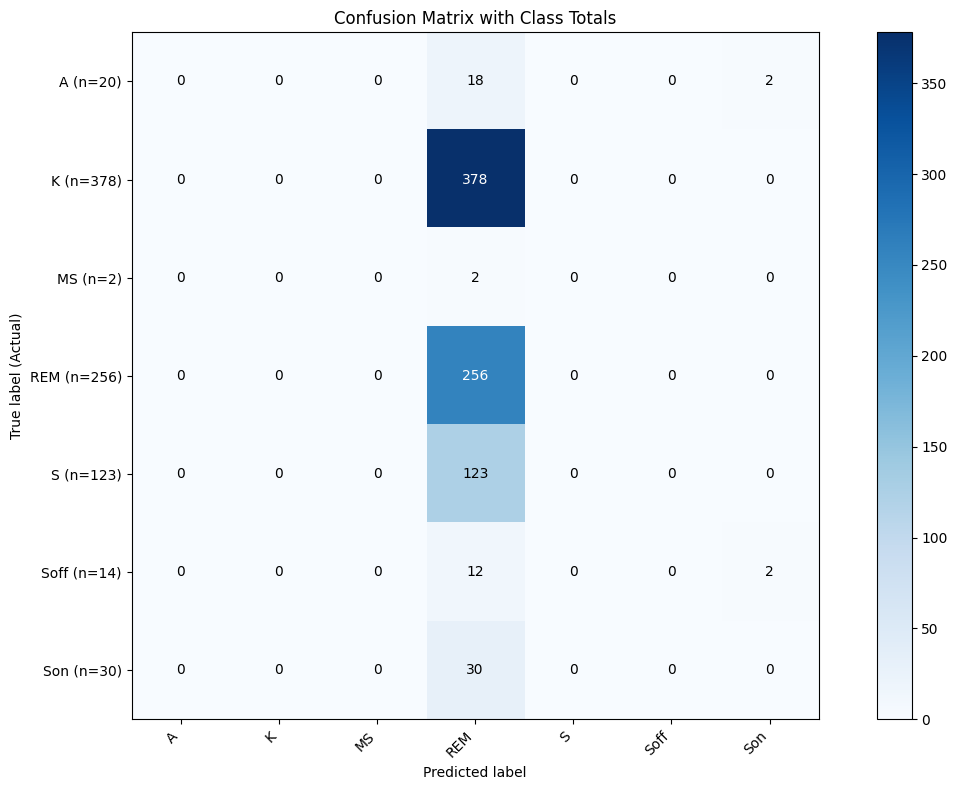

              precision    recall  f1-score   support

           A      0.000     0.000     0.000        20
           K      0.000     0.000     0.000       378
          MS      0.000     0.000     0.000         2
         REM      0.313     1.000     0.476       256
           S      0.000     0.000     0.000       123
        Soff      0.000     0.000     0.000        14
         Son      0.000     0.000     0.000        30

    accuracy                          0.311       823
   macro avg      0.045     0.143     0.068       823
weighted avg      0.097     0.311     0.148       823



c:\Users\mravi\Documents\GitHub\eeg-idun-sleep\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\mravi\Documents\GitHub\eeg-idun-sleep\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\mravi\Documents\GitHub\eeg-idun-sleep\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, 

In [72]:
# PLot confusion matrix with totals
target_names = [id2label[i] for i in range(n_classes)]
plot_confusion_matrix_with_totals(y_true, y_pred, target_names)

# Print classification report
print(classification_report(y_true, y_pred, target_names=target_names, digits=3))

### 2.7 Early Stopping

In [ ]:
from tqdm.auto import tqdm
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import copy

epochs = 10

def run_epoch(loader, train: bool):
    model.train(train)
    total_loss, correct, n = 0.0, 0, 0

    for xb, yb in tqdm(loader, leave=False):
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        loss = criterion(logits, yb)

        if train:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        total_loss += loss.item() * xb.size(0)
        correct += (logits.argmax(1) == yb).sum().item()
        n += xb.size(0)

    return total_loss / n, correct / n

def eval_all(loader):
    model.eval()
    ys, ps = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            pred = model(xb).argmax(1).cpu().numpy()
            ps.append(pred)
            ys.append(yb.numpy())
    y_true = np.concatenate(ys)
    y_pred = np.concatenate(ps)
    macro = f1_score(y_true, y_pred, average="macro")
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(n_classes))
    return macro, cm, y_true, y_pred

# Add early stopping based on macro F1
best_f1 = -1
best_state = None
best_epoch = None

for epoch in range(1, epochs + 1):
    tr_loss, tr_acc = run_epoch(train_loader, train=True)
    macro, cm, y_true, y_pred = eval_all(test_loader)
    print(f"Epoch {epoch:02d} | train loss {tr_loss:.4f} acc {tr_acc:.3f} | test macroF1 {macro:.3f}")

    if macro > best_f1:
        best_f1 = macro
        best_state = copy.deepcopy(model.state_dict())
        best_epoch = epoch

# Load best model state
model.load_state_dict(best_state)
print(f"Best model from epoch {best_epoch} with macro F1 {best_f1:.3f}")


Epoch 01 | train loss 0.7736 acc 0.746 | test macroF1 0.068


Epoch 02 | train loss 0.7049 acc 0.764 | test macroF1 0.170


Epoch 03 | train loss 0.6669 acc 0.775 | test macroF1 0.095


Epoch 04 | train loss 0.6815 acc 0.764 | test macroF1 0.116


Epoch 05 | train loss 0.6406 acc 0.766 | test macroF1 0.119


Epoch 06 | train loss 0.6033 acc 0.797 | test macroF1 0.106


Epoch 07 | train loss 0.5804 acc 0.802 | test macroF1 0.132


Epoch 08 | train loss 0.6475 acc 0.783 | test macroF1 0.262


Epoch 09 | train loss 0.5600 acc 0.805 | test macroF1 0.129


Epoch 10 | train loss 0.5574 acc 0.807 | test macroF1 0.164
Best model from epoch 8 with macro F1 0.262


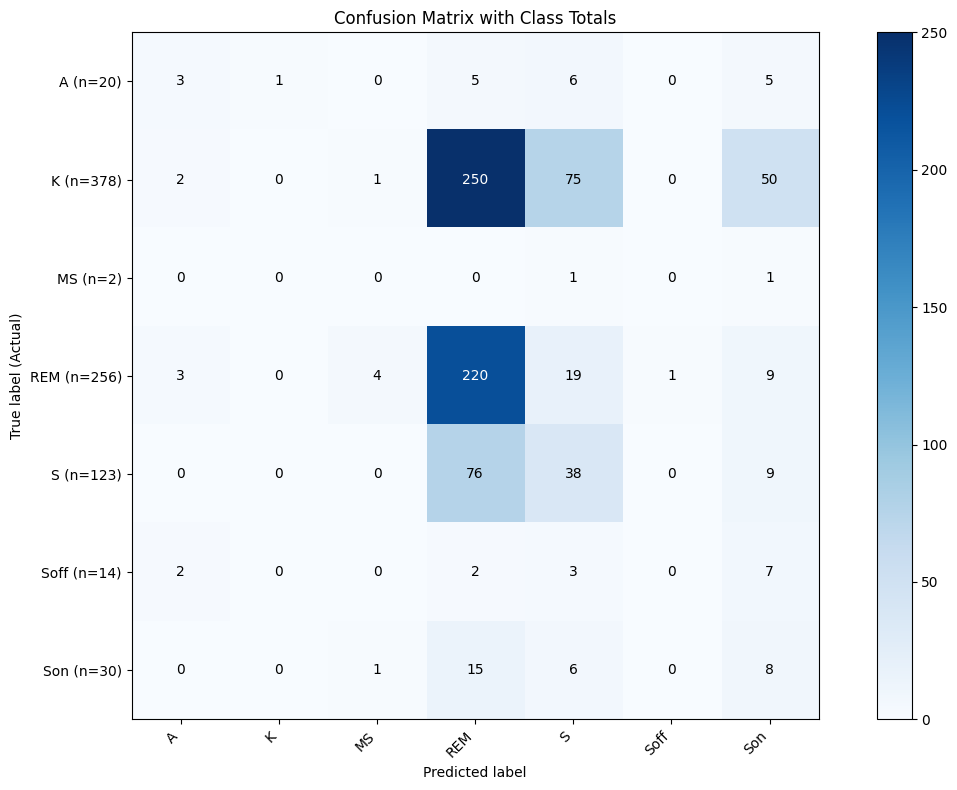

              precision    recall  f1-score   support

           A      0.300     0.150     0.200        20
           K      0.000     0.000     0.000       378
          MS      0.000     0.000     0.000         2
         REM      0.387     0.859     0.534       256
           S      0.257     0.309     0.280       123
        Soff      0.000     0.000     0.000        14
         Son      0.090     0.267     0.134        30

    accuracy                          0.327       823
   macro avg      0.148     0.226     0.164       823
weighted avg      0.169     0.327     0.218       823



In [76]:
# Predict with best model
model.load_state_dict(best_state)
macro, cm, y_true, y_pred = eval_all(test_loader)

# PLot confusion matrix with totals
target_names = [id2label[i] for i in range(n_classes)]
plot_confusion_matrix_with_totals(y_true, y_pred, target_names)

# Print classification report
print(classification_report(y_true, y_pred, target_names=target_names, digits=3))

In [ ]:
# Let's plot some K-complex eeg to understand what's going on

import matplotlib.pyplot as plt

kc_label_id = 1  # assuming 'K-complex' maps to label id 1
kc_indices = np.where(y_test_id == kc_label_id)[0]

# Plot first 5 K-complex examples
for i in range(5):
    idx = kc_indices[i]
    eeg_signal = X_test[idx, 0, :]  # (7501,)

    plt.figure(figsize=(12, 4))
    plt.plot(eeg_signal)
    plt.title(f"K-complex Example {i+1} (Index {idx})")
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude (normalized)")
    plt.grid()
    plt.show()